In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import(
    roc_auc_score,
    classification_report,
    confusion_matrix
)
import xgboost as xgb
import joblib

In [2]:
df = pd.read_csv("../data/creditcard_features.csv")

In [4]:
df.head()

,txn_timestamp_sec,embedding_feature_1,embedding_feature_2,embedding_feature_3,embedding_feature_4,embedding_feature_5,embedding_feature_6,embedding_feature_7,embedding_feature_8,embedding_feature_9,...,embedding_abs_sum,count_last_24h,amount_sum_last_24h,avg_amount_per_customer,txn_frequency,txn_type_CREDIT,txn_type_DEBIT,txn_type_TRANSFER,channel_MOBILE,channel_WEB
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,13.186192,1.0,149.62,125.623333,0.0,False,True,False,True,False
1,44299.0,1.239996,-0.985194,1.005080,-0.251323,-0.872854,1.677811,-1.451311,0.478908,0.009459,...,20.508891,2.0,178.00,125.623333,44299.0,True,False,False,False,True
2,67375.0,-0.750462,1.235814,-0.506432,-1.198784,2.421259,3.426297,-0.149277,0.161381,-0.247763,...,17.216074,3.0,183.49,125.623333,23076.0,False,False,False,False,True
3,92349.0,-3.833346,3.178578,-2.271357,-0.965729,-0.426073,-0.603747,0.227831,0.838212,2.717886,...,31.070496,4.0,231.50,125.623333,24974.0,True,False,False,False,False
4,133236.0,0.984382,-0.984506,-1.542319,3.886187,0.524369,0.877043,0.857381,-0.047189,-1.289925,...,21.545530,5.0,727.24,125.623333,40887.0,False,False,True,True,False


In [3]:
target_col= "fraud_label"
exclude_cols = {
    target_col,
    "customer_id"  
}

feature_cols = [
    c for c in df.columns
    if c not in exclude_cols and
       (np.issubdtype(df[c].dtype, np.number) or df[c].dtype == bool)
]

len(feature_cols), feature_cols[:10]

(52,
 ['txn_timestamp_sec',
  'embedding_feature_1',
  'embedding_feature_2',
  'embedding_feature_3',
  'embedding_feature_4',
  'embedding_feature_5',
  'embedding_feature_6',
  'embedding_feature_7',
  'embedding_feature_8',
  'embedding_feature_9'])

In [4]:
X = df[feature_cols]
y = df[target_col]

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify= y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, stratify= y_trainval, random_state=42)


X_train.shape, X_val.shape, X_test.shape

((182276, 52), (45569, 52), (56962, 52))

In [5]:
# Handling class imbalance
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
neg, pos, scale_pos_weight


(np.int64(181961), np.int64(315), np.float64(577.6539682539683))

In [6]:
# XGBoost Model
dtrain = xgb.DMatrix(X_train, label=y_train)
dval   = xgb.DMatrix(X_val, label=y_val)

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "scale_pos_weight": scale_pos_weight,
    "tree_method": "hist" 
}

evals = [(dtrain, "train"), (dval, "val")]

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)


[0]	train-auc:0.98645	val-auc:0.90915
[50]	train-auc:0.99986	val-auc:0.98784
[100]	train-auc:0.99994	val-auc:0.99237
[150]	train-auc:0.99998	val-auc:0.99284
[187]	train-auc:0.99999	val-auc:0.99251


In [7]:
# Evaluating model
def evaluate_model(model, X, y_true, set_name="val", top_frac=0.03):
    dmat = xgb.DMatrix(X)
    y_proba = model.predict(dmat)

    # AUC
    auc = roc_auc_score(y_true, y_proba)
    print(f"\n=== {set_name.upper()} SET ===")
    print(f"AUC: {auc:.4f}")

    y_pred = (y_proba >= 0.5).astype(int)
    print("\nClassification report @ threshold=0.5")
    print(classification_report(y_true, y_pred, digits=4))

    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

    # Precision/Recall at top-k% (ranked by probability)
    n = len(y_true)
    k = int(n * top_frac)

    # indices of top k scores
    top_idx = np.argsort(y_proba)[-k:]
    y_top = y_true.iloc[top_idx]

    precision_at_k = y_top.mean()  # since labels are 0/1
    recall_at_k = y_top.sum() / y_true.sum()

    print(f"\nTop {top_frac*100:.1f}% evaluation:")
    print(f"Precision@top{int(top_frac*100)}%: {precision_at_k:.4f}")
    print(f"Recall@top{int(top_frac*100)}%:    {recall_at_k:.4f}")

    return {
        "auc": auc,
        "precision_at_k": precision_at_k,
        "recall_at_k": recall_at_k
    }


In [8]:
metrics_val = evaluate_model(model, X_val, y_val, set_name="val", top_frac=0.03)
metrics_test = evaluate_model(model, X_test, y_test, set_name="test", top_frac=0.03)



=== VAL SET ===
AUC: 0.9925

Classification report @ threshold=0.5
              precision    recall  f1-score   support

           0     0.9997    0.9995    0.9996     45490
           1     0.7528    0.8481    0.7976        79

    accuracy                         0.9993     45569
   macro avg     0.8763    0.9238    0.8986     45569
weighted avg     0.9993    0.9993    0.9993     45569

Confusion matrix:
[[45468    22]
 [   12    67]]

Top 3.0% evaluation:
Precision@top3%: 0.0549
Recall@top3%:    0.9494

=== TEST SET ===
AUC: 0.9812

Classification report @ threshold=0.5
              precision    recall  f1-score   support

           0     0.9998    0.9998    0.9998     56864
           1     0.8660    0.8571    0.8615        98

    accuracy                         0.9995     56962
   macro avg     0.9329    0.9285    0.9307     56962
weighted avg     0.9995    0.9995    0.9995     56962

Confusion matrix:
[[56851    13]
 [   14    84]]

Top 3.0% evaluation:
Precision@top3%: 0.

In [11]:
import os
os.makedirs("models", exist_ok=True)

model_path = "models/xgb_fraud_model.bin"
features_path = "models/feature_columns.pkl"

# Saving XGBoost model
model.save_model(model_path)

# Saving feature column order (VERY important for inference)
joblib.dump(feature_cols, features_path)

print("Saved model to:", model_path)
print("Saved feature list to:", features_path)


Saved model to: models/xgb_fraud_model.bin
Saved feature list to: models/feature_columns.pkl


/var/folders/7w/jy79d_yd2wsc93tggxltg9600000gn/T/ipykernel_51214/2704682888.py:8: UserWarning: [13:01:20] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1575: Saving model in the UBJSON format as default.  You can use a file extension: `json` or `ubj` to choose between formats.
  model.save_model(model_path)


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

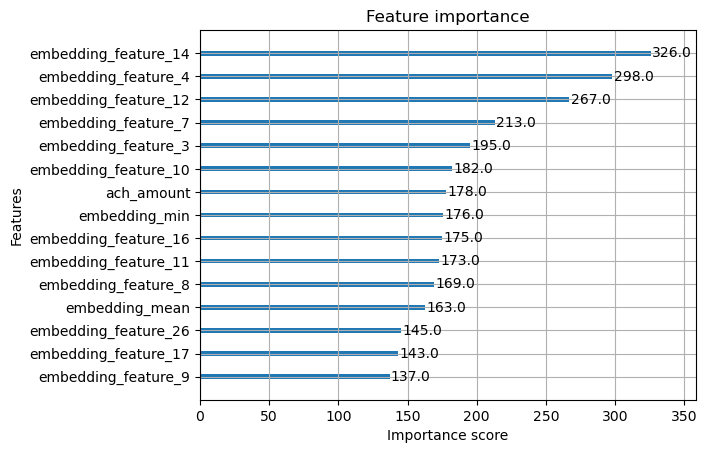

In [14]:
xgb.plot_importance(model, max_num_features=15)


In [13]:
meta = {
    "scale_pos_weight": scale_pos_weight,
    "feature_cols": feature_cols,
}

joblib.dump(meta, "models/model_meta.pkl")


['models/model_meta.pkl']